In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### Camera Caliberation Calculation

Below section contains code about camera calibration. It has been calculated in following steps.
1. object points are 3D points with z = 0, It would be same for all test images. it will be 9 * 6 grid points assuming that chess board in correct shape.
2. imgpoints are 2D points calculated using corners of the chessboard images.
3. In order to calculate camera calibration, alot of test images are used and their corners points are extracted and stroed in imgpoints.
4. objpoints and imgpoints keeps one to one correpondance between real world co-ordinate and image co-ordinate.
5. calibration metrix is calculated using object points and image points using calibrateCamera.
6. cv2.findChessboardCorners is used find the corners in chesssboards given gray image and number of corners in row and columns.
7. cv2.caliberateCamera function returns list of calibration metrix given object and image points.

#### camera calibration metrix is used to convert distorted image to un-distorted image.

In [4]:
def get_camera_calibration(images_loc, nx, ny):
    objp = np.zeros((nx * ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    for idx, fname in enumerate(images_loc):
        #print(fname)
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Find the chessboard corners
        found, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if found:
            objpoints.append(objp)
            imgpoints.append(corners)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    return mtx, dist, rvecs, tvecs

In [5]:
def get_undistored(img, cam_mtx, cam_dist):
    return cv2.undistort(img, cam_mtx, cam_dist, None, cam_mtx)

### Example of application of calibertion metrix to convert Distorted image to un-distorted images.

Un-distorted images are also saved into output director

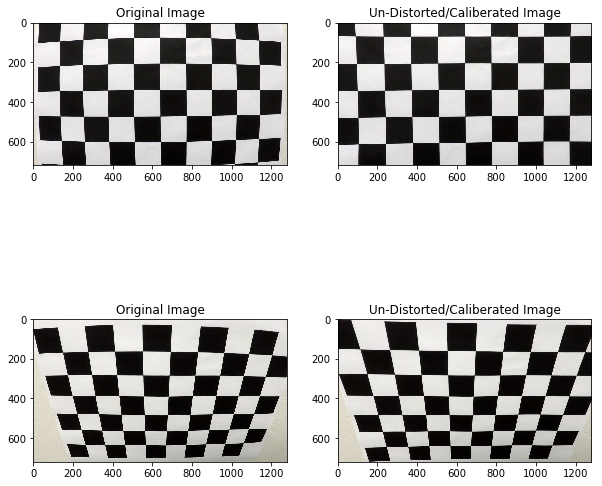

In [21]:
images_file = glob.glob('camera_cal/calibration*.jpg')
cam_mtx, cam_dist, cam_rot, cam_tran = get_camera_calibration(images_file, 9, 6) 
test_img_1 = cv2.cvtColor(cv2.imread("camera_cal/calibration1.jpg"), cv2.COLOR_BGR2RGB)
test_img_2 = cv2.cvtColor(cv2.imread("camera_cal/calibration2.jpg"), cv2.COLOR_BGR2RGB)
test_undist_1 = get_undistored(test_img_1, cam_mtx, cam_dist)
test_undist_2 = get_undistored(test_img_2, cam_mtx, cam_dist)
plt.imsave("output_images/calibration1_Caliberted.jpg", test_undist_1)
plt.imsave("output_images/calibration2_Caliberated.jpg", test_undist_2)
fig, axis = plt.subplots(2, 2, figsize=(10, 10))
axis[0, 0].imshow(test_img_1)
axis[0, 0].set_title("Original Image")

axis[0, 1].imshow(test_undist_1)
axis[0, 1].set_title("Un-Distorted/Caliberated Image")

axis[1, 0].imshow(test_img_2)
axis[1, 0].set_title("Original Image")

axis[1, 1].imshow(test_undist_2)
axis[1, 1].set_title("Un-Distorted/Caliberated Image")

## Pipeline (single images)

### 1. Input Image (test_images/straight_lines1.jpg)

cv2 reads image in BGR but pipeline function mostly works with assumption of RGB image. In first step, we convert BGR to RGB image.

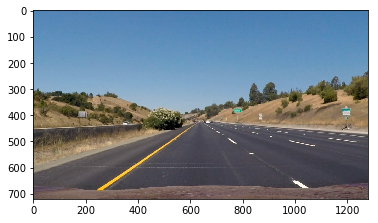

In [23]:
lane_image = cv2.imread('test_images/straight_lines1.jpg')
lane_image = cv2.cvtColor(lane_image, cv2.COLOR_BGR2RGB)
plt.imshow(lane_image)

### 2. Distoration correction of the image generated by camers lenses.

This is achieved by applying distortion metrix / camera caliberation metrix. Camera caliberation metrix is generated above and will be same for same camera. Here, it is assumed that all below and above chess images is being generated from same camera, hence same camera caliberation metrix will be applied in all the pipeline images to retrieve un-distorted image.

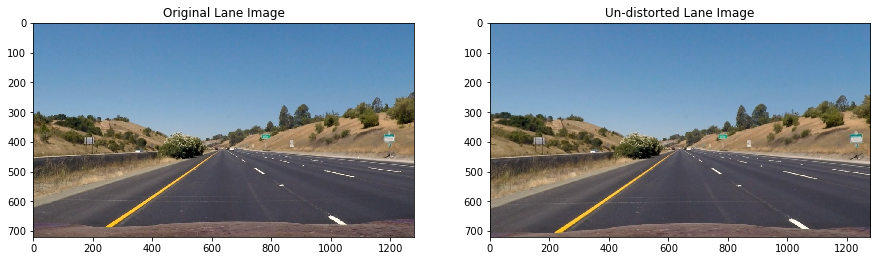

In [39]:
lane_image_undist = get_undistored(lane_image, cam_mtx, cam_dist)
fig, (im1, im2) = plt.subplots(1, 2, figsize = (15,15))
im1.imshow(lane_image)
im1.set_title('Original Lane Image')
im2.imshow(lane_image_undist)
im2.set_title('Un-distorted Lane Image')

### 3.a Color and Gradient Threshold (Thresholded Image)- 

Color threshold identifies yellow and white lane in image.
Gradient threshold indentifies shape of the lane and remove un-interested region of lane.

Thresholded Image has two components - a. Color Indentify component (Color thresholded) and Shape Indentification components (Shape thresholded).

Thresholded Image = Color thresholded & Shape thresholded.

Below contains description and reasonining behind choosing the threshold/color value for color and shape thresholded image.

In [40]:
def magnitude_gradient(img, sobel_kernel=3, thresh_min = 0, thresh_max = 255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Take the gradient in x and y separately
    # Calculate the magnitude 
    sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobel_scale = np.uint8(255 * sobel/np.max(sobel)) 
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(sobel_scale)
    # Return this mask as your binary_output image
    binary_output[(sobel_scale > thresh_min) & (sobel_scale <= thresh_max)] = 1
    #binary_output = np.copy(img) # Remove this line
    return binary_output

In [41]:
def direction_gradient(img, sobel_kernel=3, thresh_min=0.0, thresh_max = np.pi/2):
    # Apply the following steps to img
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir > thresh_min) & (grad_dir <= thresh_max)] = 1
    return binary_output

In [42]:
def RGB_image_gradient(img, orient='x', thresh_min = 0, thresh_max = 255):
    # Convert to gray image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Derivative along axis
    if orient == 'x':
        absolute_sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        
    if orient == 'y':
        absolute_sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * absolute_sobel/np.max(absolute_sobel))
    
    # Keeping the derivatives of interest (between of min and max threshold) and converting to binary image
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh_min) & (scaled_sobel < thresh_max)] = 1
    return binary_output
    

In [43]:
def hls_select(img, channel = 's', thresh_min = 0, thresh_max = 255):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    channel_idx = -1
    if channel == 'h':
        channel_idx = 0
    elif channel == 'l':
        channel_idx = 1
    elif channel == 's':
        channel_idx = 2
    channel_img = hls[:,:,channel_idx]
    # Return a binary image of threshold result
    binary_output = np.zeros_like(channel_img)
    binary_output[(channel_img > thresh_min) & (channel_img <= thresh_max)] = 1
    return binary_output

In [44]:
def rgb_select(img, channel = 'r', thresh_min = 0, thresh_max = 255):
    channel_idx = -1
    if channel == 'r':
        channel_idx = 0
    elif channel == 'g':
        channel_idx = 1
    elif channel == 'b':
        channel_idx = 2
    channel_img = img[:,:,channel_idx]
    # Return a binary image of threshold result
    binary_output = np.zeros_like(channel_img)
    binary_output[(channel_img > thresh_min) & (channel_img <= thresh_max)] = 1
    return binary_output

In [45]:
def detect_color_of_lane(img):
    r_select_binary = rgb_select(img=img, channel='r', thresh_min=160, thresh_max=255)
    g_select_binary = rgb_select(img=img, channel='g', thresh_min=160, thresh_max=255)
    l_remove_shadow = hls_select(img=img, channel='l', thresh_min=110, thresh_max=255)
    lane_color = np.zeros_like(r_select_binary)
    lane_color[(r_select_binary == 1) & (g_select_binary == 1) & (l_remove_shadow == 1)] = 1
    
    return lane_color

In [47]:
def detect_shape_of_lane(img):
    # S component is indepent of color. This helps to maintains the intensity component intact. 
    s_select_binary = hls_select(img,channel='s', thresh_min=100, thresh_max=255)
    #Also considering the only componenet which has gradient towards x direction
    x_grad_binary = RGB_image_gradient(img=img, orient='x', thresh_min=20, thresh_max=200)
    dir_grad_binary = direction_gradient(img, sobel_kernel=15, thresh_min=0.7, thresh_max=1.5)
    lane_shape = np.zeros_like(x_grad_binary)
    lane_shape[(((x_grad_binary == 1) & (dir_grad_binary == 1)) | (s_select_binary == 1))] = 1
    
    return lane_shape

In [49]:
def get_thresholded_image(img):
    # Filtering the Color part of Image. Lane could be either White or Green. 
    # This can be retrieved by putting high threshold on Red and Green. 
    # There could also be shadow part in the image. This can be removed by putting higher value on L part of HSL color model
    
    lane_color = detect_color_of_lane(img)
    
    lane_shape = detect_shape_of_lane(img)
    
    output_img = np.zeros_like(lane_shape)
    
    output_img[(lane_color == 1) & ((lane_shape == 1)) ] = 1
    
    return output_img

In [52]:
x_gradient_img = RGB_image_gradient(lane_image_undist, 'x', thresh_min=10, thresh_max=200)

y_gradient_img = RGB_image_gradient(lane_image_undist, 'y', thresh_min=20, thresh_max=200)

magnitude_gradient_img = magnitude_gradient(lane_image_undist)

direction_gradient_img = direction_gradient(lane_image_undist, sobel_kernel=15, thresh_min=0.5, thresh_max=1.5)

s_gradient_img = hls_select(lane_image_undist,channel='s', thresh_min=80, thresh_max=255)

l_gradient_img = hls_select(lane_image_undist, channel='l', thresh_min=110, thresh_max=255)

h_gradient_img = hls_select(lane_image_undist, channel='h', thresh_min=100, thresh_max=170)

r_gradient_img = rgb_select(lane_image_undist, channel='r', thresh_min=160, thresh_max=255)

g_gradient_img = rgb_select(lane_image_undist, channel='g', thresh_min=160, thresh_max=255)

b_gradient_img = rgb_select(lane_image_undist, channel='b', thresh_min=120, thresh_max=255)

lane_shape = detect_shape_of_lane(lane_image_undist)
lane_color = detect_color_of_lane(lane_image_undist)

In [61]:
def get_thresholded_image_area_of_interest(img):
    thresh_img = get_thresholded_image(img)
    
    height, width = thresh_img.shape

        
    region_of_interest = np.array([[width * 0.1, height * 1.0],\
                                   [width * 0.45, height * 0.40],\
                                   [width * 0.55, height * 0.40],\
                                   [width * 0.90, height * 1.0]]).astype(int)
    
    mask = np.zeros_like(thresh_img)
    #print(region_of_interest)
    cv2.fillPoly(mask, [region_of_interest], 1)
    masked_img_thresholded = cv2.bitwise_and(thresh_img, mask)
    
    return masked_img_thresholded

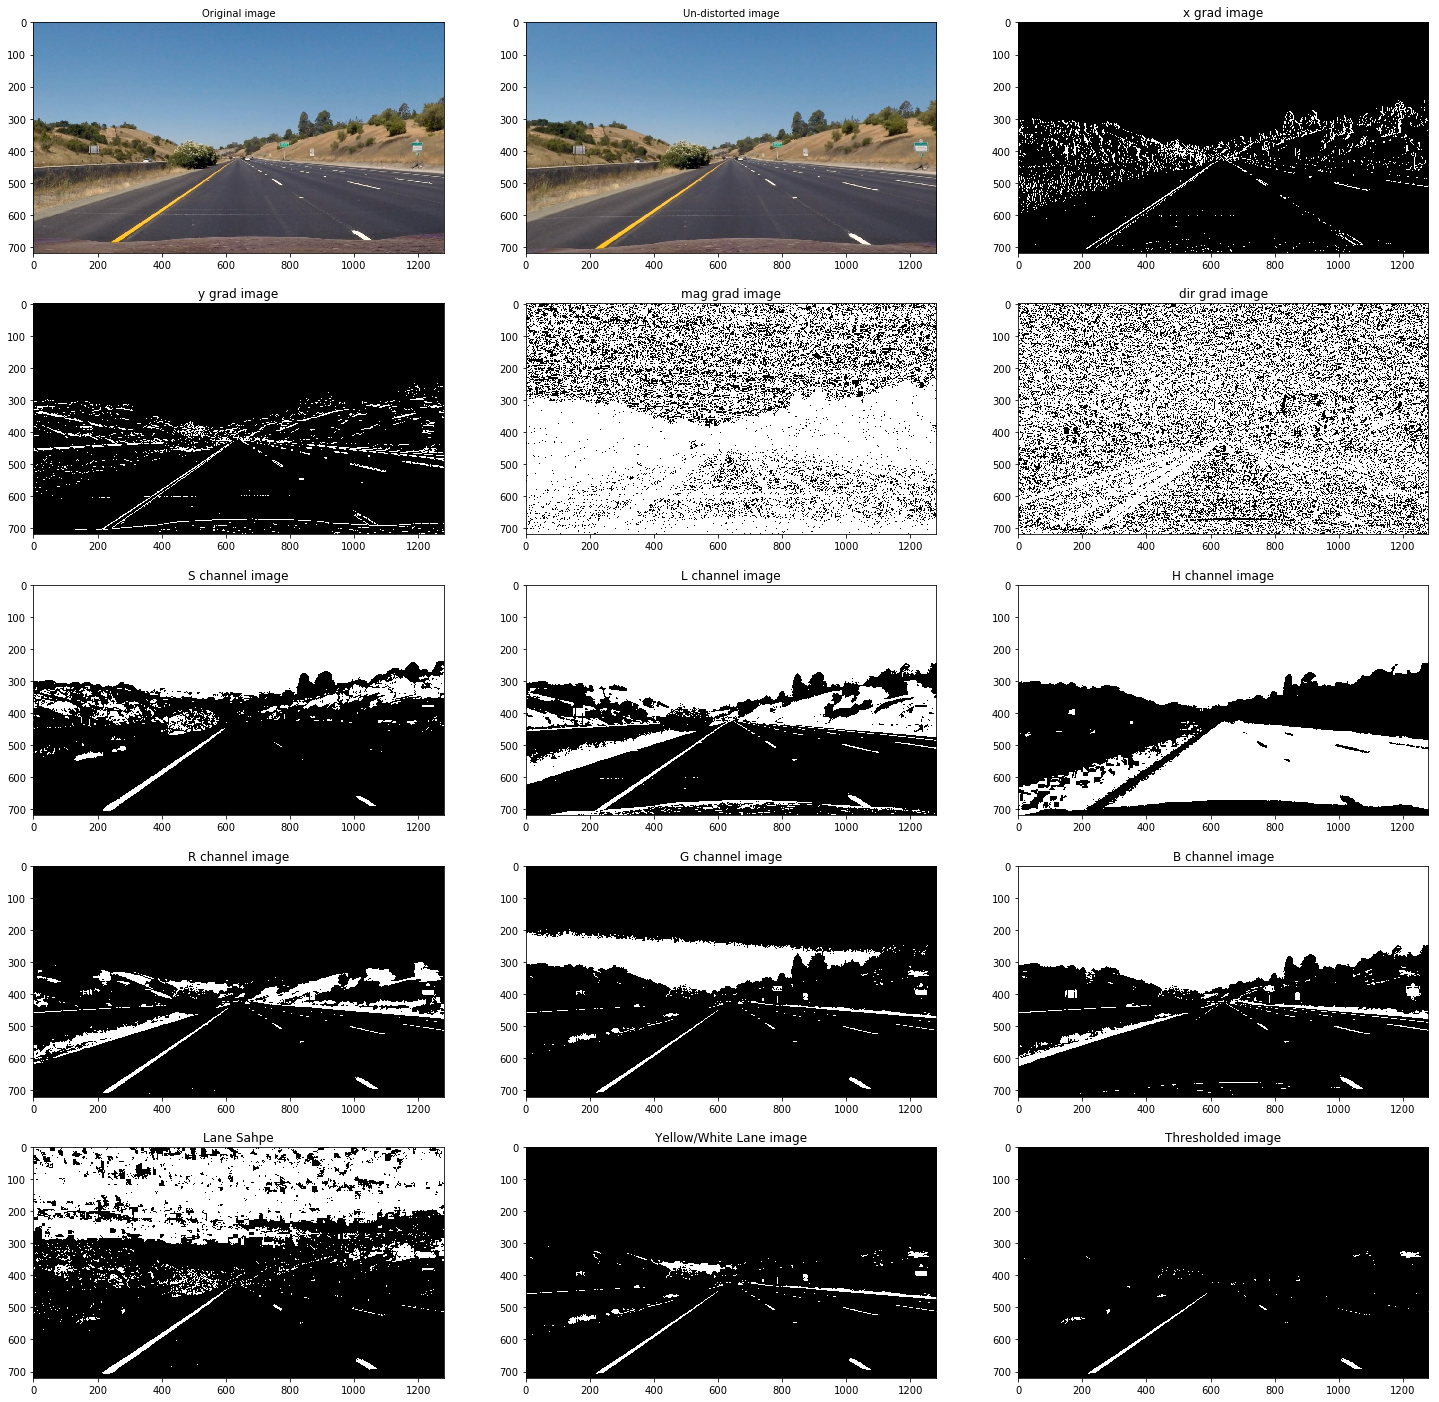

In [56]:
#Displaying all thresholding image
fig, axis = plt.subplots(5, 3, figsize=(25, 25))
axis[0, 0].imshow(lane_image)
axis[0, 0].set_title('Original image', fontsize =10)

axis[0, 1].imshow(lane_image_undist)
axis[0, 1].set_title('Un-distorted image', fontsize = 10)

axis[0, 2].imshow(x_gradient_img, 'gray')
axis[0, 2].set_title('x grad image')

axis[1, 0].imshow(y_gradient_img, 'gray')
axis[1, 0].set_title('y grad image')

axis[1, 1].imshow(magnitude_gradient_img, 'gray')
axis[1, 1].set_title('mag grad image')

axis[1, 2].imshow(direction_gradient_img, 'gray')
axis[1, 2].set_title('dir grad image')

axis[2, 0].imshow(s_gradient_img, 'gray')
axis[2, 0].set_title('S channel image')

axis[2,1].imshow(l_gradient_img, 'gray')
axis[2,1].set_title('L channel image')

axis[2, 2].imshow(h_gradient_img, 'gray')
axis[2, 2].set_title('H channel image')

axis[3, 0].imshow(r_gradient_img, 'gray')
axis[3, 0].set_title('R channel image')

axis[3, 1].imshow(g_gradient_img, 'gray')
axis[3, 1].set_title('G channel image')

axis[3, 2].imshow(b_gradient_img, 'gray')
axis[3, 2].set_title('B channel image')

axis[4,0].imshow(lane_shape, 'gray')
axis[4,0].set_title("Lane Sahpe")

axis[4, 1].imshow(lane_color, 'gray')
axis[4, 1].set_title('Yellow/White Lane image')

axis[4, 2].imshow(get_thresholded_image(lane_image_undist), 'gray')
axis[4, 2].set_title('Thresholded image')

### 3.b Gradient and Thresholding of image

### Color Thresholded Image detection - 
Color of lane is being retrieved - R and G component of RGB color image. If R and G color both lies in the range of threshold, It will be Yellow or White lane. L component is used for intensity of color to remove shadows part of the image.

### Lane Shape Threshold Image detection - 
Shape of lane is being extracted by x-componet derivative and nearly to vertical direction. Lane has high x-gradient and also direction of angle is near to y-axis. S-component of HLS is more robust to shadows, and also used  for detecting the shape of lane.

#### Final Lane shape is being extracted by conjuction of color thresholded image and lane shape thresholded image.

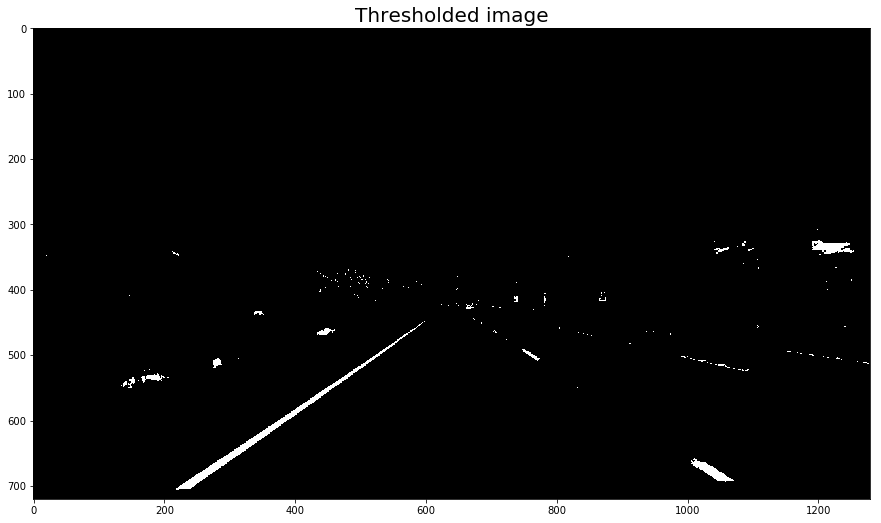

In [60]:
fig, im = plt.subplots(1, 1, figsize=(15, 15))
im.imshow(get_thresholded_image(lane_image_undist), 'gray')
im.set_title('Thresholded image', fontsize=20)

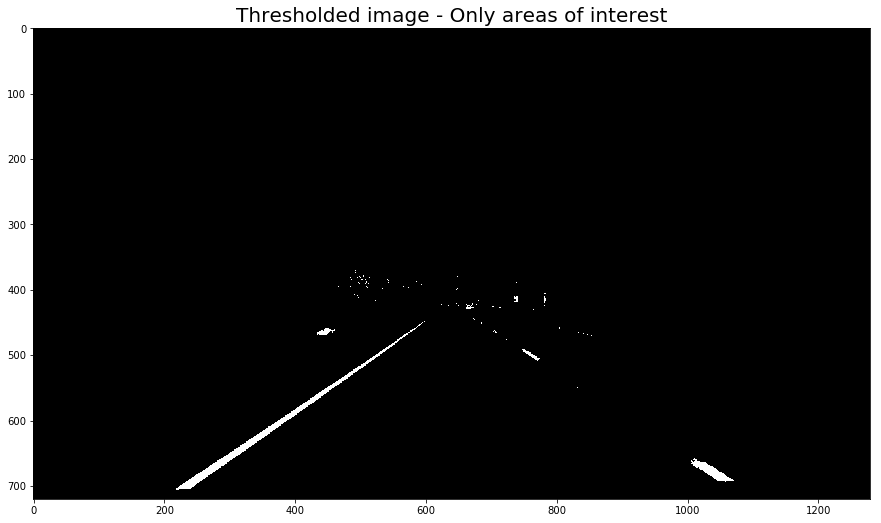

In [67]:
fig, im = plt.subplots(1, 1, figsize=(15, 15))
im.imshow(get_thresholded_image_area_of_interest(lane_image_undist), 'gray')
im.set_title('Thresholded image - Only areas of interest', fontsize=20)

In [68]:
thresh_bin_img.shape

(720, 1280)

In [182]:
from IPython.display import HTML
from IPython.display import display

def generate_html_for_table(matrix):
    tablestr = "<table>"
    # first row is header
    for i in range(len(matrix)):
        tablestr = tablestr + "<tr>"
        for j in range(len(matrix[i])):
            if( i ==0):
                tablestr += "<th>" + matrix[i][j] + "</th>"
            else:
                tablestr += "<td>" + matrix[i][j] + "</td>"
        tablestr = tablestr + "</tr>"
    tablestr = tablestr + "</table>"
    return tablestr

In [187]:
# trans_points = [
#     ["Source", "Destination"],
#     ["(220, 720)", "(320, 720)"],
#     ["(1100, 720)", "(920, 720)"],
#     ["(720, 470)", "(920, 1)"],
#     ["(570, 470)", "(320, 1)"]
# ]
# generate_html_for_table(trans_points)

## 4. Perspective Transformation to rectify binary image

### Following points used for finding perspective metrixs.
<table><tr><th>Source</th><th>Destination</th></tr><tr><td>(220, 720)</td><td>(320, 720)</td></tr><tr><td>(1100, 720)</td><td>(920, 720)</td></tr><tr><td>(720, 470)</td><td>(920, 1)</td></tr><tr><td>(570, 470)</td><td>(320, 1)</td></tr></table>

Above points are choosen by manually looking the source and destination bounding box. Below also displays new images after applying perspective transformation.

In [188]:
src = np.float32([[220, 720], [1100, 720], [720, 470], [570, 470]])
dst = np.float32([[320, 720], [920, 720] , [920, 1],   [320, 1]])

In [189]:
M = cv2.getPerspectiveTransform(src, dst)
img_size = (thresh_bin_img.shape[1], thresh_bin_img.shape[0])
warped = cv2.warpPerspective(thresh_bin_img, M, img_size , flags=cv2.INTER_LINEAR)
Minv = cv2.getPerspectiveTransform(dst, src)

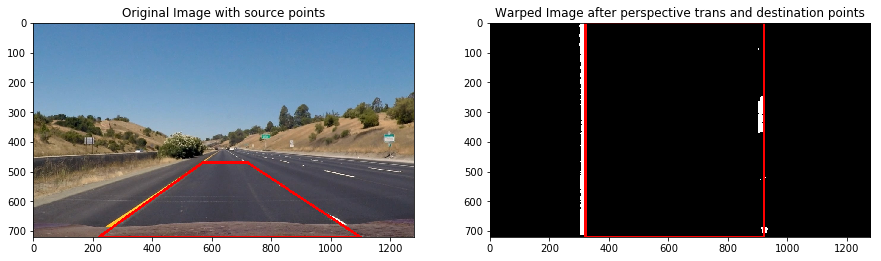

In [190]:
fig, (left, right) = plt.subplots(1, 2, figsize = (15, 15))
lane_image_srcpts = lane_image.copy()
pts = src.astype(int)
cv2.polylines(lane_image_srcpts, [pts.reshape((-1,1,2))], True, [255, 0, 0], thickness=7)

left.imshow(lane_image_srcpts)
left.set_title("Original Image with source points")

pts = dst.astype(int).reshape((-1,1,2))
warped_withDest = np.dstack((warped, warped, warped))*255
cv2.polylines(warped_withDest, [pts], True, [255, 0, 0], thickness=7)
#cv2.draw(warped, [pts], True, [255, 0, 0], thickness=7)
right.imshow(warped_withDest)
right.set_title("Warped Image after perspective trans and destination points")

## 5. Lane pixel indentification

In [203]:
def get_line_predicted(binary_img, slid_win_count = 9, margin=100, minpix=50, draw_slidW_rect=False):
    # Take a histogram of bottom half of the image to choose bottom-left and bottom-right point.
    # This would work as starting point
    hist = np.sum(binary_img[binary_img.shape[0]/9:, :], axis=0)
    
    out_img = np.dstack((binary_img, binary_img, binary_img))*255
        
    midpoint = np.int(hist.shape[0]/2)
    bottom_left_x = np.argmax(hist[:midpoint])
    bottom_right_x = np.argmax(hist[midpoint:]) + midpoint
    
    window_height = np.int(binary_img.shape[0]/slid_win_count)
    
    leftx_current = bottom_left_x
    rightx_current = bottom_right_x
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = []
    right_lane_inds = []
    
    #Generating the rectangle boxes
    for window in range(slid_win_count):
        # Identify window boundaries in x and yboundary point (and right and left)
        win_y_low = binary_img.shape[0] - (window + 1) * window_height
        win_y_high = binary_img.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw boundary rectangle
        if (draw_slidW_rect):
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 4) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 4) 
            
        # Identify non-zero pixel in sliding windows
        
        # Identify the x and y positions of all nonzero pixels in the image
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
            # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        #Choose center of mean the selected points of windows.
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            #print (leftx_current)
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img, hist

In [204]:
leftx_pixs, lefty_pixs, rightx_pixs, righty_pixs, outImage, hist = get_line_predicted(warped, draw_slidW_rect=True)

### 5.a Histogram to detect left bottom and right bottom pixel of the lane

Max peak of left and right indentifies the bottom left and bottom right pixel of the lane.

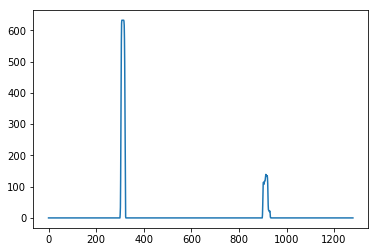

In [205]:
plt.plot(hist)

### 5.b Sliding Windows search to indentifies the pixel lanes

Starting from bottom left and bottom right points retrieved through above histogram strategy, It slides rectangular windows towards the line to find lane pixels.
It chosses all the pixels as part of line, which comes under sliding windows. New Center of sliding windows rectangle is mean center of all the points in sliding rectangle. Sliding windows center choosing strategy leads to moving of sliding windows rectangle towards the curve lane.

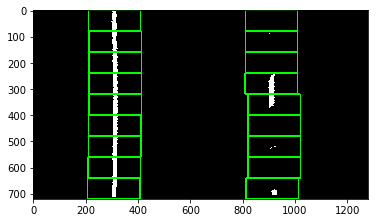

In [207]:
plt.imshow(outImage)

### 5.c Lane fitting with all selected pixels

polynomial curve is fits by above selected pixels. Polynomial curve is drawn as lane line.

#### In below Image, red line is lane line fits from sets of pixels choosen at above points

In [216]:
def polynomial_fit(leftx_pixs, lefty_pixs, rightx_pixs, righty_pixs, y_axis_size):
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty_pixs, leftx_pixs, 2)
    right_fit = np.polyfit(righty_pixs, rightx_pixs, 2)
    
    ploty = np.linspace(0, y_axis_size -1 , y_axis_size )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

(720, 0)

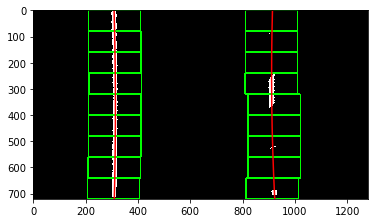

In [218]:
left_fitx, right_fitx, ploty = polynomial_fit(leftx_pixs, lefty_pixs, rightx_pixs, righty_pixs, warped.shape[0])
plt.imshow(outImage)
plt.plot(left_fitx, ploty, color='red', )
plt.plot(right_fitx, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### 6. Lane Line detection pipeline on a single Image

In [219]:
def lane_finding_pipeline(img, interm_images=False):
    # Get Un-Distorted Image
    img_undist = get_undistored(img, cam_mtx, cam_dist)
    
    # Get Thresholded Image from Un-distorted Image
    img_thresh = get_thresholded_image_area_of_interest(img_undist)
    
    # Get warped Image
    img_size = (thresh_bin_img.shape[1], thresh_bin_img.shape[0])
    img_warped = cv2.warpPerspective(img_thresh, M, img_size , flags=cv2.INTER_LINEAR)
    
    # Finding the points of left and right lane.
    leftx, lefty, rightx, righty, image_withrect, hist = get_line_predicted(img_warped, draw_slidW_rect=interm_images)
    
    # Fit the polynomials for left and right lane
    left_fitx, right_fitx, ploty = polynomial_fit(leftx, lefty, rightx, righty, img_warped.shape[0])
    
    # Drawing the polynomials points on the original image
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)
    
    outputs = {}
    outputs["result"] = result
    if interm_images:
        outputs["original"] = img
        outputs["undistort"] = img_undist
        outputs["threshold"] = img_thresh
        outputs["warped"] = img_warped
        outputs["image_slidingwindows"] = image_withrect
    return outputs
    

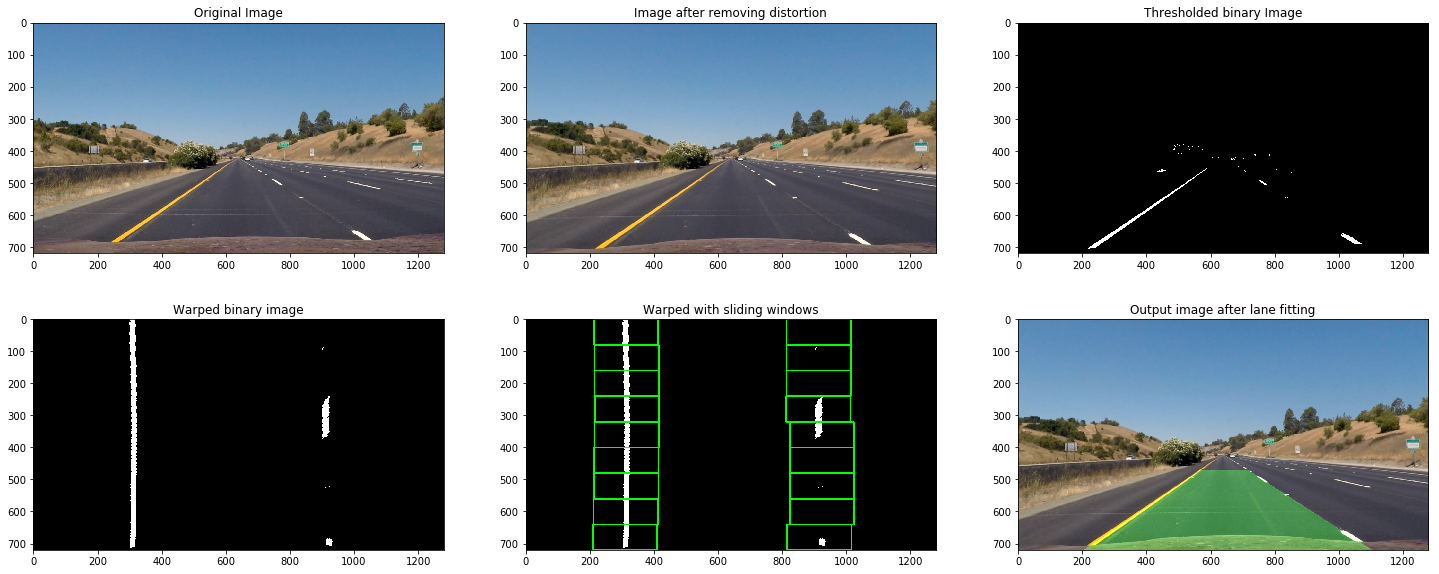

In [227]:
outputs = lane_finding_pipeline(lane_image, interm_images=True)
fig, axis = plt.subplots(2, 3, figsize=(25, 10))
axis[0, 0].imshow(lane_image)
#plt.imshow(outputs["undistort"])
axis[0, 0].imshow(outputs["original"])
axis[0, 0].set_title("Original Image")

axis[0, 1].imshow(outputs["undistort"])
axis[0, 1].set_title("Image after removing distortion")

axis[0, 2].imshow(outputs["threshold"], 'gray')
axis[0, 2].set_title("Thresholded binary Image")

axis[1,0].imshow(outputs["warped"], 'gray')
axis[1, 0].set_title("Warped binary image")

axis[1,1].imshow(outputs["image_slidingwindows"])
axis[1,1].set_title("Warped with sliding windows")

axis[1, 2].imshow(outputs["result"])
axis[1, 2].set_title("Output image after lane fitting")

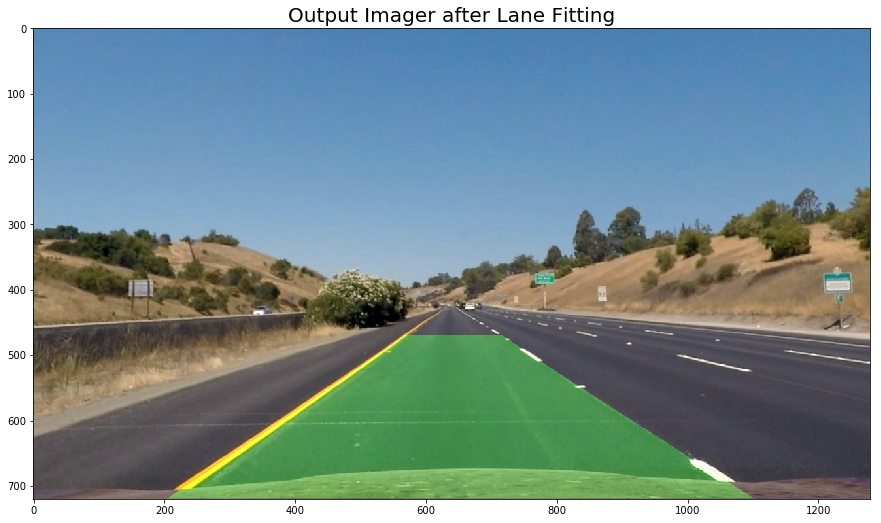

In [229]:
fig, im = plt.subplots(1, 1, figsize=(15, 15))
im.imshow(outputs["result"])
im.set_title('Output Imager after Lane Fitting', fontsize=20)
plt.imshow(outputs["result"])

## Pipeline Videos

Here is Youtube link - https://youtu.be/e0i-RC6C0VI
Video is also updadated in Github account

In [230]:
faild_img = None
def process_image(image):
    global failed_img
    failed_img = image
    return lane_finding_pipeline(image)["result"]

In [231]:
white_output = 'project_video_withLaneMarking.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_withLaneMarking.mp4
[MoviePy] Writing video project_video_withLaneMarking.mp4


100%|█████████▉| 1260/1261 [02:53<00:00,  7.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_withLaneMarking.mp4 

CPU times: user 11min 15s, sys: 31.9 s, total: 11min 47s
Wall time: 2min 54s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Discussion - Challenges and scope of improvement

### 1. Image Thresholding -
#### Challenge
a. Most challenging part of thresholding is indetifying the appropriate threshold for color and gradient. It requires a lot of combination and intuition to try.
b. Second challenge involves color combinations. In different brigthness, selection of color channel plays important role.

#### Scope of improvements
a. Could have done better by trying other Color models.
b. Could have been done better by doing some gridy search with all possible combinations of color and threshold value to find most optimal color and threshold

### 2. Perspective Transformation
#### Challenge
a. Choosing of source and reference points requires trying alot of combinations manually.

#### Scope of improvements -
a. Source and Destination points could have been deduced mathematically by using thresholded binary images with considerable margin. This strategy could have been applied on 10-100 images and most optimal is choosen.
